# News Classification Project
### It Coding for Data Science - Module II

**Author**: Francesca Mariana Riondato

**Student ID**: 5205965

**email**: francesca.riondato01@icatt.it

The project uses the APIs of New York Times (Archive) to retrieve the data, applies NLP methods and classifies the news into section names (target classes), using the following attributes: 
- Keywords
- News desk
- Author

In [1]:
import requests
import random
import nltk
#nltk.download('stopwords') 
import string
from nltk.corpus import wordnet
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
api_key = 'EOa5qVCxFqpA6SAPIZHDBDIGedNKAWKs'
endpoint = 'https://api.nytimes.com/svc/archive/v1/2019/1.json'
params = {
    'api-key': api_key
}

In [3]:
response = requests.get(endpoint, params = params)

In [4]:
data = response.json()

In [5]:
data

{'copyright': 'Copyright (c) 2020 The New York Times Company. All Rights Reserved.',
 'response': {'docs': [{'abstract': 'From the Treaty of Versailles to Prohibition, the events of that year shaped America, and the world, for a century to come. ',
    'web_url': 'https://www.nytimes.com/2018/12/31/opinion/1919-america.html',
    'snippet': 'From the Treaty of Versailles to Prohibition, the events of that year shaped America, and the world, for a century to come. ',
    'lead_paragraph': 'Throughout 2019, The New York Times Opinion section will publish an occasional series of essays on the ways in which the events of 1919 shaped the following century. ',
    'source': 'The New York Times',
    'multimedia': [{'rank': 0,
      'subtype': 'xlarge',
      'caption': None,
      'credit': None,
      'type': 'image',
      'url': 'images/2019/01/01/opinion/01Widmer1-Sub/01Widmer1-Sub-articleLarge.jpg',
      'height': 467,
      'width': 600,
      'subType': 'xlarge',
      'crop_name': '

The class News is created to handle better the data. 

In [6]:
class News:
    def __init__(self, id, author, keywords, news_desk, section_name):
        self._id = id
        self._author = author
        self._keywords = keywords
        self._news_desk = news_desk
        self._section_name = section_name #target category
    
    def getSectionName(self):
        return self._section_name

    def replaceSectionName(self):
        if self._section_name in ['Reader Center', 'Briefing', 'U.S.', 'The Upshot', 'New York', 'Admin', 'Today’s Paper', 'Corrections', 'Business Day', 'Sunday Review', 'World', 'Obituaries', 'Opinion']:
            self._section_name = 'Breaking News'
        elif self._section_name in ['Real Estate', 'Guides', 'Style', 'Fashion & Style', 'Food', 'Education', 'Magazine', 'Smarter Living', 'Travel', 'Your Money', 'Neediest Cases']:
            self._section_name = 'Lifestyle'
        elif self._section_name in ['Arts', 'Books', 'T Magazine', 'Theater', 'Movies', 'Crosswords & Games', 'Podcasts', 'Lens', 'The Learning Network', 'Multimedia/Photos', 'T Brand', 'Watching']:
            self._section_name = 'Arts & Entertainment'
        elif self._section_name in ['Science', 'Technology', 'Climate', 'Health', 'Well']:
            self._section_name = 'Technology & Science'
    
    def find_synonyms(self, word_list):
        synonyms = set()
        for word in word_list: 
            for synset in wordnet.synsets(word):
                for lemma in synset.lemmas(): #base form of the synomym
                    synonyms.add(lemma.name())
        return ' '.join(list(synonyms))
    
    def preprocessing(self):
        #predefined set of words with little semantic meaning 
        stopWords = set(nltk.corpus.stopwords.words("english"))
        #find synonyms of keywords
        kwords_syn = self.find_synonyms(self._keywords)
        
        #split text into tokens
        tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') #tokenizer of text on pattern (seq of alphanum characters)
        text = f"{self._keywords} {kwords_syn} {self._news_desk} {self._author}" #analysed attributes
        tokens = tokenizer.tokenize(text.lower()) #normalisation
        final = []
        for t in tokens:
            if len(t)>1 and t not in stopWords: #only meaningful words
                if not all(char in string.punctuation for char in t): #remove punctuation marks
                    if not t.isdigit(): #delete numbers
                        if t not in final: #no duplicates
                            final.append(t)
        return ' '.join(final) 

The list containing all the news is created. 

In [7]:
docs = data['response']['docs']

In [8]:
news = []
for i in range(0, len(docs)):
    ident = docs[i]['_id']
    author = docs[i]['byline']['original'].replace('By ', '').replace(' ', '') #name and surname as a single word
    k_list = docs[i]['keywords']
    keywords = [k['value'] for k in k_list]    
    news_desk = docs[i]['news_desk']
    section_name = docs[i]['section_name']
    article = News(ident, author, keywords, news_desk, section_name)
    news.append(article)

In [9]:
print(f'Number of news: {len(news)}')

Number of news: 4482


In [10]:
unique_section_names = set()
for article in news:
    section_name = article.getSectionName()
    unique_section_names.add(section_name)
    
print(unique_section_names)

{'Lens', 'Real Estate', 'Obituaries', 'Style', 'Podcasts', 'Technology', 'Business Day', 'Movies', 'Opinion', 'The Learning Network', 'Your Money', 'Education', 'Travel', 'Sunday Review', 'Multimedia/Photos', 'Arts', 'Magazine', 'Crosswords & Games', 'Admin', 'T Brand', 'Books', 'Sports', 'New York', 'Science', 'Reader Center', 'U.S.', 'T Magazine', 'Well', 'Climate', 'Smarter Living', 'Neediest Cases', 'Watching', 'Theater', 'World', 'The Upshot', 'Food', 'Briefing', 'Guides', 'Fashion & Style', 'Corrections', 'Health', 'Today’s Paper'}


Similar categories are put together to enhance the classification process.

In [11]:
for article in news:
    article.replaceSectionName()

In [12]:
unique_section_names2 = set()
for article in news:
    section_name = article.getSectionName()
    unique_section_names2.add(section_name)
    
print(unique_section_names2)

{'Technology & Science', 'Breaking News', 'Lifestyle', 'Sports', 'Arts & Entertainment'}


The data is preprocessed.

In [13]:
random.shuffle(news)

In [14]:
final_news = []
for i in news:
    final_news.append(i.preprocessing())

In [15]:
categories = []
for i in news:
    categories.append(i.getSectionName())

In [16]:
final_news

['kerala india sabarimala women rights girls demonstrations protests riots hinduism bharat republic_of_india hindooism nilotabrizy',
 'united states politics government jones doug moore roy alabama elections senate federal election commission rumors misinformation social media alabama_river camellia_state heart_of_dixie al investigative alanblinder',
 'television home box office farrell colin vaughn vince fukunaga cary true detective tv program television_receiver idiot_box telly television_system telecasting goggle_box television_set video boob_tube tv_set culture briantallerico',
 'great britain withdrawal eu brexit house commons labour party bercow john may theresa london england legislatures parliaments politics government democracy theory philosophy foreign ellenbarryandstephencastle',
 'global warming environment greenhouse gas emissions carbon dioxide coal natural trump donald united states politics government rhodium group llc char surroundings environs ember surround climate b

The data is split into train and test sets.

In [17]:
train_news, test_news, train_categories, test_categories = train_test_split(final_news, categories, test_size = 0.2, random_state = 42)

In [18]:
print(f'Number of train_news: {len(train_news)}\nNumber of test_news: {len(test_news)}')

Number of train_news: 3585
Number of test_news: 897


The data is classified.

In [19]:
vectorizer = CountVectorizer() #converts text into numerical features
train_data = vectorizer.fit_transform(train_news) #fit and transform train
test_data = vectorizer.transform(test_news) #transform test

In the first approach, the Multinomial Naive Bayes classifier is used. 

In [20]:
nbclassifier = MultinomialNB() #Naive Bayes

nbclassifier.fit(train_data, train_categories) #train
predicted_categories = nbclassifier.predict(test_data)

In [100]:
for predicted_label, true_label in zip(predicted_categories, test_categories):
    print(f"Predicted: {predicted_label} vs True: {true_label}")

Predicted: Breaking News vs True: Breaking News
Predicted: Breaking News vs True: Breaking News
Predicted: Breaking News vs True: Breaking News
Predicted: Breaking News vs True: Breaking News
Predicted: Breaking News vs True: Breaking News
Predicted: Breaking News vs True: Breaking News
Predicted: Breaking News vs True: Breaking News
Predicted: Arts & Entertainment vs True: Arts & Entertainment
Predicted: Lifestyle vs True: Lifestyle
Predicted: Breaking News vs True: Breaking News
Predicted: Lifestyle vs True: Lifestyle
Predicted: Breaking News vs True: Breaking News
Predicted: Breaking News vs True: Breaking News
Predicted: Technology & Science vs True: Technology & Science
Predicted: Breaking News vs True: Breaking News
Predicted: Breaking News vs True: Breaking News
Predicted: Arts & Entertainment vs True: Arts & Entertainment
Predicted: Breaking News vs True: Breaking News
Predicted: Lifestyle vs True: Lifestyle
Predicted: Sports vs True: Sports
Predicted: Lifestyle vs True: Lifest

In [22]:
unique_categories, counts = np.unique(predicted_categories, return_counts = True)

for category, count in zip(unique_categories, counts):
    print(f"{category}: {count}")

Arts & Entertainment: 191
Breaking News: 462
Lifestyle: 129
Sports: 55
Technology & Science: 60


In [23]:
conf_matrix = confusion_matrix(test_categories, predicted_categories)

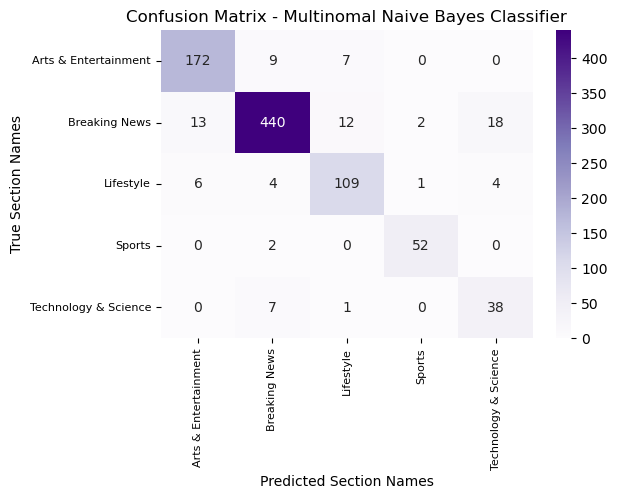

In [57]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot = True, cmap = 'Purples', fmt = 'd')
plt.xlabel('Predicted Section Names')
plt.ylabel('True Section Names')
plt.title('Confusion Matrix - Multinomal Naive Bayes Classifier')
labels = ['Arts & Entertainment', 'Breaking News', 'Lifestyle', 'Sports', 'Technology & Science']
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks + 0.5, labels, rotation = 90, fontsize = 8)
plt.yticks(tick_marks + 0.5, labels, rotation = 0, fontsize = 8)
plt.gca().set_xticklabels(labels)
plt.show()

In [25]:
accuracynb = accuracy_score(test_categories, predicted_categories)
print(accuracynb)

0.9041248606465998


In the second approach, the Random Forest classifier is used. 

In [29]:
rfclassifier = RandomForestClassifier()

rfclassifier.fit(train_data, train_categories) #train
predicted_categories_rf = rfclassifier.predict(test_data)

In [30]:
conf_matrix2 = confusion_matrix(test_categories, predicted_categories_rf)

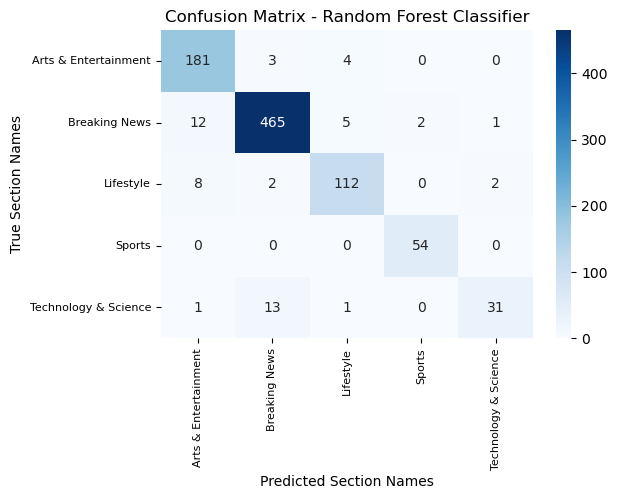

In [31]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix2, annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted Section Names')
plt.ylabel('True Section Names')
plt.title('Confusion Matrix - Random Forest Classifier')
labels = ['Arts & Entertainment', 'Breaking News', 'Lifestyle', 'Sports', 'Technology & Science']
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks + 0.5, labels, rotation = 90, fontsize = 8)
plt.yticks(tick_marks + 0.5, labels, rotation = 0, fontsize = 8)
plt.gca().set_xticklabels(labels)
plt.show()

In [32]:
accuracyrf = accuracy_score(test_categories, predicted_categories_rf)
print(accuracyrf)

0.939799331103679


In [59]:
acc = [accuracynb, accuracyrf]
classif = ['Multinomial Naive Bayes', 'Random Forest']

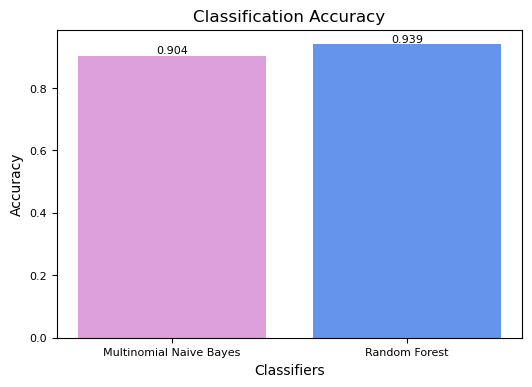

In [99]:
plt.figure(figsize=(6, 4))
plt.bar(classif, acc, color = ['plum', 'cornflowerblue'])
for i in range(len(acc)):
    plt.text(i, acc[i], str(acc[i])[:5], ha = 'center', va = 'bottom', size = 8)
plt.title('Classification Accuracy')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

Both classifiers demonstrate effective news classification. 
However, the Random Forest classifier outperforms the Multinomial Naive Bayes classifier with an improvement of about 0.3% in terms of classification accuracy. 

Nevertheless, it is important to mention that the categories may include news with topics that could overlap between multiple categories. Therefore, achieving a higher accuracy could be possible with specific-content news. 